<a href="https://colab.research.google.com/github/kudikala-sahasra/Covid-19-Dashboard-/blob/main/20MT30037_Lohum_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1 - **Feature Extraction**

Importing the important libraries and the dataset

In [2]:
import pandas as pd

df = pd.read_csv("/content/Part1.csv")

In [3]:
df.head()

,Unnamed: 0,timestamp,soc,voltage,current
0,0,2021-12-12 04:41:20,87,56.3,0.0
1,1,2021-12-12 04:41:20,87,56.3,0.0
2,2,2021-12-12 04:41:20,87,56.3,0.0
3,3,2021-12-12 04:43:31,87,56.3,0.0
4,4,2021-12-12 04:43:31,87,56.3,0.0


###1. **Cleaning the Data**

Remove missing values

In [16]:
df = df.dropna()

In [17]:
df.shape

(81138, 6)

Removing the Outliers

In [18]:
#This function removes the value which lie outside the 25th and 75th percentile of the dataset
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df = remove_outlier(df, 'soc')
df = remove_outlier(df, 'voltage')

Parse the time stamps column

In [19]:
df['time_parsed'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['time_parsed'])   #Sorting the DataFrame according to the timestamp

###2. Algorithm to obtain the FECs that the given battery has undergone

create a "charge status" column that indicates whether a battery is charging or discharging, you can calculate the difference between consecutive charge values

In [20]:
df['charge_status'] = df['soc'] - df['soc'].shift(1)

Creating a charge_current column which gives the current difference while charging. The charge_current value is 0 if the battery is discharging.

In [21]:
df['charge_current']=0

charge_status = -1
for i in range(df.shape[0]):
  if(df['charge_status'].iloc[i]!=0):
    charge_status = df['charge_status'].iloc[i]

  if(charge_status>0):
    df['charge_current'].iloc[i] = df['current'].iloc[i]
  else:
    df['charge_current'].iloc[i] = 0


<ipython-input-21-b6df6898b772>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['charge_current'].iloc[i] = 0
<ipython-input-21-b6df6898b772>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [22]:
df.head(1000)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current
71954,71954,2021-11-09 07:05:22,59,52.3,0.0,2021-11-09 07:05:22,NaN,0.0
71955,71955,2021-11-09 07:05:22,93,57.3,0.0,2021-11-09 07:05:22,34.0,0.0
71956,71956,2021-11-09 07:07:33,93,56.7,12.8,2021-11-09 07:07:33,0.0,12.8
71957,71957,2021-11-09 07:07:33,93,57.1,2.9,2021-11-09 07:07:33,0.0,2.9
71958,71958,2021-11-09 07:07:33,93,57.1,0.0,2021-11-09 07:07:33,0.0,0.0
...,...,...,...,...,...,...,...,...
20715,20715,2021-11-11 04:57:52,39,50.5,3.5,2021-11-11 04:57:52,0.0,0.0
20718,20718,2021-11-11 05:00:03,38,50.4,3.1,2021-11-11 05:00:03,-1.0,0.0
20717,20717,2021-11-11 05:00:03,38,50.5,2.1,2021-11-11 05:00:03,0.0,0.0
20716,20716,2021-11-11 05:00:03,39,50.4,4.4,2021-11-11 05:00:03,1.0,4.4


The following expression finds the fraction of cycle completed at each timestep by adding only the positive values of charge_status and then dividing them by 100

In [23]:
df['cycles'] = df['charge_status'].map(lambda x : x if x>0 else 0).cumsum()/100

In [24]:
df.head(1000)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles
71954,71954,2021-11-09 07:05:22,59,52.3,0.0,2021-11-09 07:05:22,NaN,0.0,0.00
71955,71955,2021-11-09 07:05:22,93,57.3,0.0,2021-11-09 07:05:22,34.0,0.0,0.34
71956,71956,2021-11-09 07:07:33,93,56.7,12.8,2021-11-09 07:07:33,0.0,12.8,0.34
71957,71957,2021-11-09 07:07:33,93,57.1,2.9,2021-11-09 07:07:33,0.0,2.9,0.34
71958,71958,2021-11-09 07:07:33,93,57.1,0.0,2021-11-09 07:07:33,0.0,0.0,0.34
...,...,...,...,...,...,...,...,...,...
20715,20715,2021-11-11 04:57:52,39,50.5,3.5,2021-11-11 04:57:52,0.0,0.0,2.24
20718,20718,2021-11-11 05:00:03,38,50.4,3.1,2021-11-11 05:00:03,-1.0,0.0,2.24
20717,20717,2021-11-11 05:00:03,38,50.5,2.1,2021-11-11 05:00:03,0.0,0.0,2.24
20716,20716,2021-11-11 05:00:03,39,50.4,4.4,2021-11-11 05:00:03,1.0,4.4,2.25


The Total FECs is given by the following code

In [25]:
int(df['cycles'].iloc[-1])

54

###3. Capacity of Battery

Calculating the time difference

In [26]:
df['time_secs'] = df['time_parsed'] - df['time_parsed'].shift(1)
df['time_secs'] = df['time_secs'].map(lambda x : (pd.Timedelta(x, unit='h').total_seconds())).fillna(0)

In [27]:
df.head(1000)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles,time_secs
71954,71954,2021-11-09 07:05:22,59,52.3,0.0,2021-11-09 07:05:22,NaN,0.0,0.00,0.0
71955,71955,2021-11-09 07:05:22,93,57.3,0.0,2021-11-09 07:05:22,34.0,0.0,0.34,0.0
71956,71956,2021-11-09 07:07:33,93,56.7,12.8,2021-11-09 07:07:33,0.0,12.8,0.34,131.0
71957,71957,2021-11-09 07:07:33,93,57.1,2.9,2021-11-09 07:07:33,0.0,2.9,0.34,0.0
71958,71958,2021-11-09 07:07:33,93,57.1,0.0,2021-11-09 07:07:33,0.0,0.0,0.34,0.0
...,...,...,...,...,...,...,...,...,...,...
20715,20715,2021-11-11 04:57:52,39,50.5,3.5,2021-11-11 04:57:52,0.0,0.0,2.24,0.0
20718,20718,2021-11-11 05:00:03,38,50.4,3.1,2021-11-11 05:00:03,-1.0,0.0,2.24,131.0
20717,20717,2021-11-11 05:00:03,38,50.5,2.1,2021-11-11 05:00:03,0.0,0.0,2.24,0.0
20716,20716,2021-11-11 05:00:03,39,50.4,4.4,2021-11-11 05:00:03,1.0,4.4,2.25,0.0


Finding the Change of Charge at each timestamp (Q = I*t)

In [28]:
df['charge_change'] = df['charge_current']*(df['time_secs']/3600)
df.head(1000)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles,time_secs,charge_change
71954,71954,2021-11-09 07:05:22,59,52.3,0.0,2021-11-09 07:05:22,NaN,0.0,0.00,0.0,0.000000
71955,71955,2021-11-09 07:05:22,93,57.3,0.0,2021-11-09 07:05:22,34.0,0.0,0.34,0.0,0.000000
71956,71956,2021-11-09 07:07:33,93,56.7,12.8,2021-11-09 07:07:33,0.0,12.8,0.34,131.0,0.465778
71957,71957,2021-11-09 07:07:33,93,57.1,2.9,2021-11-09 07:07:33,0.0,2.9,0.34,0.0,0.000000
71958,71958,2021-11-09 07:07:33,93,57.1,0.0,2021-11-09 07:07:33,0.0,0.0,0.34,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20715,20715,2021-11-11 04:57:52,39,50.5,3.5,2021-11-11 04:57:52,0.0,0.0,2.24,0.0,0.000000
20718,20718,2021-11-11 05:00:03,38,50.4,3.1,2021-11-11 05:00:03,-1.0,0.0,2.24,131.0,0.000000
20717,20717,2021-11-11 05:00:03,38,50.5,2.1,2021-11-11 05:00:03,0.0,0.0,2.24,0.0,0.000000
20716,20716,2021-11-11 05:00:03,39,50.4,4.4,2021-11-11 05:00:03,1.0,4.4,2.25,0.0,0.000000


Finding the index where 10th cycle ends

In [29]:
cycle_10th=0
for i in range(df.shape[0]):
  if(df['cycles'].iloc[i]>=10):
    cycle_10th = i
    break

Following expression gives the Capacity of the battery (in Ah)

In [30]:
# Summing all the Positive change of charges at all timestamps till the 10th cycle
# and then divide by 10 to obtain the average over 10 cycles

df.head(cycle_10th)['charge_change'].sum()/10

43.86210555555555

#Part 2 - Regression

Importing the data and library

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error

df2 = pd.DataFrame(pd.read_excel("Part2.csv.xlsx"))

In [33]:
df2.head()

,Cycle_Index,Discharge_Capacity (Ah)
0,3,1.050
1,4,2.082
2,5,1.041
3,6,1.041
4,7,1.041


Creating SOH column as per the given definition

In [34]:
initial_capacity = df2['Discharge_Capacity (Ah)'].iloc[0]
df2['SOH'] = df2['Discharge_Capacity (Ah)']/initial_capacity
df2.head()

,Cycle_Index,Discharge_Capacity (Ah),SOH
0,3,1.050,1.000000
1,4,2.082,1.982857
2,5,1.041,0.991429
3,6,1.041,0.991429
4,7,1.041,0.991429


###Cleaning the data

Sorting the DataFrame according to the Cycle Index

In [35]:
df2 = df2.sort_values(by=['Cycle_Index'])

Plotting our dataset

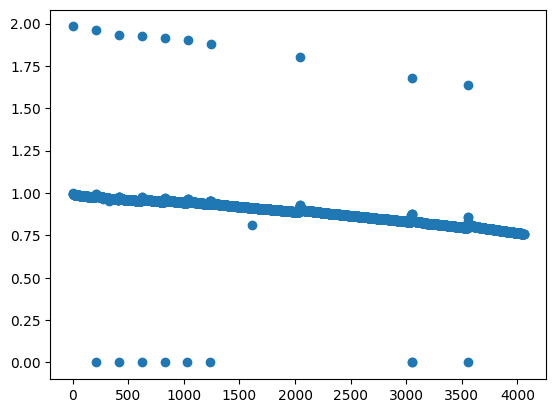

In [36]:
plt.scatter(df2['Cycle_Index'], df2['SOH'])
plt.show()

We can see from the above plot that there are some outliers in the data,
So we'll proceed to remove these outliers

In [37]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df2 = remove_outlier(df2, 'SOH')

Visualizing the data again

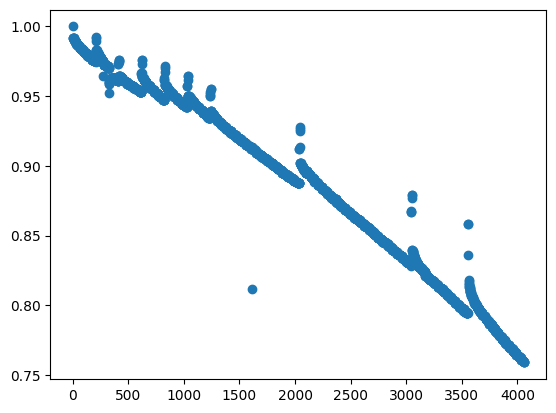

In [38]:
plt.scatter(df2['Cycle_Index'], df2['SOH'])
plt.show()

###1. Modelling the SOH of the cell as a function of cycle number

Preprocessing the data and splitting them into training and test datasets

In [39]:

X = np.array(df2['Cycle_Index']).reshape(-1, 1)
y = np.array(df2['SOH']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Creating a learning regression model using Scikit-learn library and training it on the train dataset

In [40]:
regr = LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

Testing the model on test dataset

In [41]:
print(regr.score(X_test, y_test))

0.9869078028840595


Plotting the results predicted by the model (red line)

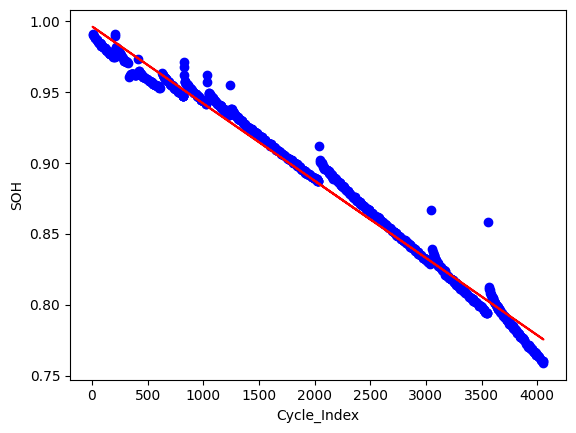

In [42]:
y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='r')
plt.xlabel('Cycle_Index')
plt.ylabel('SOH')
plt.show()

Creating the predict_SOH function as per the question

In [43]:
def predict_SOH(df_in):
  X_in = np.array(df_in['Cycle_Index']).reshape(-1, 1)
  pred_SOH = regr.predict(X_in)
  return pred_SOH

print(predict_SOH(df2))

[[0.99642422]
 [0.9963152 ]
 [0.99626069]
 ...
 [0.77550052]
 [0.77544601]
 [0.7753915 ]]


###2. Obtain RUL

Predict after how many cycles model reaches 80% SOH

In [44]:
life_cycle = np.array(0).reshape(1,-1)
y=0
while(True):
  y = regr.predict(life_cycle)
  if(y<=0.8):     #Count cycles until SOH decreases to 80%
    break
  life_cycle+=1
print(life_cycle[0][0])

3607


RUL after the following Cycles: 500, 1000, 2000, 3000 and 3500

In [45]:
rul_500 = life_cycle[0][0] - 500
rul_1000 = life_cycle[0][0] - 1000
rul_2000 = life_cycle[0][0] - 2000
rul_3000 = life_cycle[0][0] - 3000
rul_3500 = life_cycle[0][0] - 3500

print("RUL at 500th Cycle : ",rul_500)
print("RUL at 1000th Cycle : ",rul_1000)
print("RUL at 2000th Cycle : ",rul_2000)
print("RUL at 3000th Cycle : ",rul_3000)
print("RUL at 3500th Cycle : ",rul_3500)

RUL at 500th Cycle :  3107
RUL at 1000th Cycle :  2607
RUL at 2000th Cycle :  1607
RUL at 3000th Cycle :  607
RUL at 3500th Cycle :  107


### 3. Evaluate the performance of the model

Calculating the error estimates using Scikit-learn module

In [46]:
#This function estimates the MAE and RMSE errors between the Actual and predicted SOH values using the Scikit-learn libraries
def Estimate_error(df_in):
  y_test = df_in['SOH']
  y_pred = predict_SOH(df_in)
  mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
  rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  return (rmse, mae)

In [47]:
rmse,mae = Estimate_error(df2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Print the performance metrics

In [48]:
print("MAE:",mae)
print("RMSE:",rmse)

MAE: 0.006132542881257661
RMSE: 0.007835723123454682


In [49]:
initial_capacity = df2['Discharge_Capacity (Ah)'].iloc[0]
df2['SOH'] = df2['Discharge_Capacity (Ah)']/initial_capacity

print(Estimate_error(df2))

(0.007835723123454682, 0.006132542881257661)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#Summary

###Part 1 - Feature Extraction

Task 1


---

In this initial section, I have performed preprocessing of data. <br>
I used the dropna function available in pandas library to drop the null values.<br>
I have used a custom function to remove the outliers present in the data by excluding those values which lie outside the inter-quartile range.
<br>
I have also parsed the timestamps so that I can sort the table according to the time and it remains consistent with chronology of the battery charging and discharging.


Task 2

---

In this section I have written an algorithm to find the full equivalent cycles of the battery. I created a charge status column which monitors the change in the SOC. Then I have created a charge_current column which monitors the change in charging current of the battery.
<br>
After that I create a cycles column which captures the cycles completed at a particular timestamp. This is calculated by adding all the charge_status cummulatively and then dividing them by 100. In this way, the last value gives the total FEC completed by the battery.

Task 3

---

Initially, I have calculated the change in time at each step. Now, I multiplt each of the time change with the current change to obtain the change in charge. Then, I have found the index where 10th cycle ends iteratively. Finally, I summed the change in charges over 10 cycles and divided them by 10 to get the average Capacity of the battery.


###Part 2 - Regression

Task 1

---

Before starting, I cleaned the provided dataset by removing outliers using the same method as in the previous task. I then preprocessed the data and split it into training and testing sets using the Scikit-learn and NumPy libraries. For model training, I used Scikit-learn's LinearRegression function. I chose a linear regression model because, based on data visualization, it appeared to follow a linear pattern, which suggested it would yield better results. Training the model on 75% of the dataset took approximately 1 second. The input features were the 'Cycle_index' and the target variable was the 'SOH' column of the DataFrame.
<br>
After that I have tested the model on the test dataset and plotted  the comparison between the actual and predicted results. Finally, I have created the predict_SOH function as asked in the question.


Task 2

---

In this section I have calculated the remaining useful life (RUL) of the battery. First, I have tried to find the total number of cycles which is useful in its lifetime. So I thought of an algorithm where we count the cycles until SOH decreases to 80%.
So, in this way the RUL comes out to be :
<br>RUL at 500th Cycle :  3108
<br>RUL at 1000th Cycle :  2608
<br>RUL at 2000th Cycle :  1608
<br>RUL at 3000th Cycle :  608
<br>RUL at 3500th Cycle :  108

Task 3

---

In this section, I have calculated the performance metrics of my model. The metrics used are MAE and RMSE. These are estimated errors calculated using Scikit's functions.<br>
The values come out to be :<br>
MAE: 0.0061<br>
RMSE: 0.0078